In [1]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-06-10 03:47:28.872313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 03:47:28.872355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 03:47:28.872982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 03:47:28.876908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 03:47:29.389195: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


2024-06-10 03:47:30.008981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 03:47:30.035997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 03:47:30.036050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 03:47:30.039246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 03:47:30.039297: I external/local_xla/xla/stream_executor

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
DATA_PATH = Path() / "datasets" / "emnist"
DATA_PATH.mkdir(parents=True, exist_ok=True)

### get the data(EMNIST)

In [4]:
! pip install --upgrade tfds-nightly

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [6]:
import tensorflow_datasets as tfds

# try:
#     tem = tfds.image_classification.EMNIST()
#     tem.download_and_prepare()
# except:
#     class EMNIST(tfds.image_classification.EMNIST):
#         URL = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
#         
#     tem = EMNIST()
#     tem.download_and_prepare()

nameList = ["balanced",
            "byclass",
            "bymerge",
            "digits",
            "letters",
            "mnist"]

# datasets name list
# 0 - balanced
# 1 - byclass
# 2 - bymerge
# 3 - digits
# 4 - letters
# 5 - mnist
# 
# do not use 3~5, this only includes part of EMNIST
dtype = 1

# default - byclass
(train_bal, test_bal), info_bal = tfds.load("emnist" + "/" + nameList[0], split=['train','test'], as_supervised=True, with_info=True)
(train_class, test_class), info_class = tfds.load("emnist" + "/" + nameList[1], split=['train','test'], as_supervised=True, with_info=True)
(train_merge, test_merge), info_merge = tfds.load("emnist" + "/" + nameList[2], split=['train','test'], as_supervised=True, with_info=True)


현재(2024-05-06) 작동하지 않음 - https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip 해당 사이트로 renewal 된 것을 아직 번영하지 않음
> 고침! 새 link로 상속시키면 됨
> 
2024-05-09 - tfds 쪽 URL가 고쳐져서 정상적으로 쓰면 됨

최초로 사용하는 datasets들은 처음에 다운로드하는 데 시간이 걸림. 그 후는 이미 존재하는 내용을 사용해서 바로 됨

In [7]:
# deprecated code

# if not os.path.isfile(dpath / "archive.zip"):
#     import requests
#     
#     url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
#     response = requests.get(url)
#     
#     with open(dpath / "archive.zip", mode="wb") as file:
#         file.write(response.content)

[cannot load..](https://github.com/tensorflow/datasets/issues/5356)

In [8]:
# deprecated code

# print(dpath)
# 
# import zipfile
# arc = zipfile.ZipFile(dpath / 'archive.zip','r')
# 
# nameList = ["emnist-balanced",
#             "emnist-byclass",
#             "emnist-bymerge",
#             "emnist-digits",
#             "emnist-letters",
#             "emnist-mnist"]
# 
# # datasets name list
# # 0 - balanced
# # 1 - byclass
# # 2 - bymerge
# # 3 - digits
# # 4 - letters
# # 5 - mnist
# 
# dtype = 0
# 
# train_bal = pd.read_csv(arc.open(nameList[dtype] + "-train.csv"))
# test_bal = pd.read_csv(arc.open(nameList[dtype] + "-test.csv"))

In [9]:
# train_bal = pd.DataFrame()
# 
# for cnt, chunk in enumerate(pd.read_csv(dpath / "emnist-byclass-train.csv",chunksize=10000)):
#     train_bal = pd.concat([train_bal, chunk])


In [10]:
print(info_bal)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/home/choi-wsl/tensorflow_datasets/emnist/balanced/3.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    s

In [11]:
info_bal.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
})

In [12]:
train_size = info_bal.splits['train'].num_examples
test_size = info_bal.splits['test'].num_examples
print(f'train_size: {train_size} 개\ntest_size: {test_size} 개')

train_size: 112800 개
test_size: 18800 개


In [13]:
# or
tfds.as_dataframe(train_bal.take(4), info_bal)

2024-06-09 04:13:56.412958: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,31
1,,35
2,,30
3,,7


In [13]:
# deprecated code

# num_columns = 785
# 
# # Create column names
# columns = ['label'] + list(range(1, num_columns))
# 
# # Assign column names to the DataFrames
# train_bal.columns = columns
# test_bal.columns = columns
# 
# # Reset index
# train_bal = train_bal.reset_index(drop=True)
# test_bal = test_bal.reset_index(drop=True)
# 
# # Extract features and labels
# x_train = train_bal.drop(['label'], axis=1)
# y_train = train_bal['label']
# x_test = test_bal.drop(['label'], axis=1)
# y_test = test_bal['label']
# 
# # Display the first few rows of the DataFrame
# print(train_bal.head())
# print(test_bal.head())

In [14]:
# train_bal["label"].value_counts()

In [15]:
tfds.benchmark(train_bal, batch_size=32)


************ Summary ************


  0%|          | 0/112800 [00:00<?, ?it/s]

Examples/sec (First included) 194996.20 ex/sec (total: 3609632 ex, 18.51 sec)
Examples/sec (First only) 917.03 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 195362.74 ex/sec (total: 3609600 ex, 18.48 sec)


,duration,num_examples,avg
first+lasts,18.511294,3609632,194996.198349
first,0.034895,32,917.028179
lasts,18.476399,3609600,195362.744694


In [14]:
print(info_bal.features["label"].num_classes)
print(info_bal.features["label"].names)

47
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']


## labeling

In [15]:
def getClasses(type):
    file = open("datasets/emnist/emnist-" + nameList[type] +"-mapping.txt",'r')
    lines = file.readlines()
    
    classes = []
    
    for line in lines:
        classes.append(chr(int(line.split()[-1])))
    
    file.close()
    
    return classes

In [16]:
classes_bal = getClasses(0)
classes_class = getClasses(1)
classes_merge = getClasses(2)

In [17]:
print(classes_bal)
print(classes_class)
print(classes_merge)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


each label - [link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

## visualization

simple example using `tfds.show_examples()`

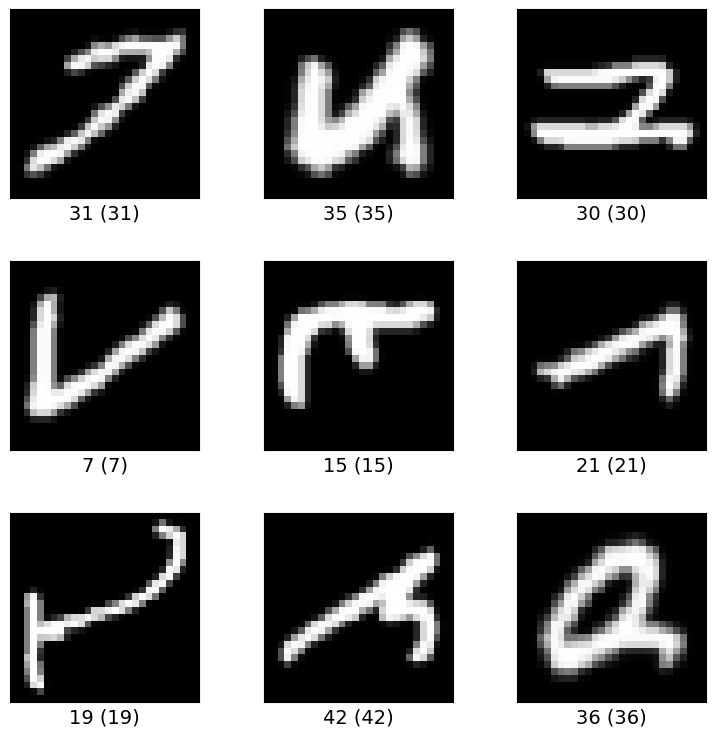

In [24]:
fig = tfds.show_examples(train_bal, info_bal)

문제점:
> 1. label이 integer로 되어있음. 학습하는 동안은 이게 맞지만 사람이 직접 확인할 때는 문제가 생김(머가 먼지 모름)
> 2. 이미지가 90도 돌아가 있음. 이거는 `transpose()`로 간단히 해결할 수는 있음(아마도...)

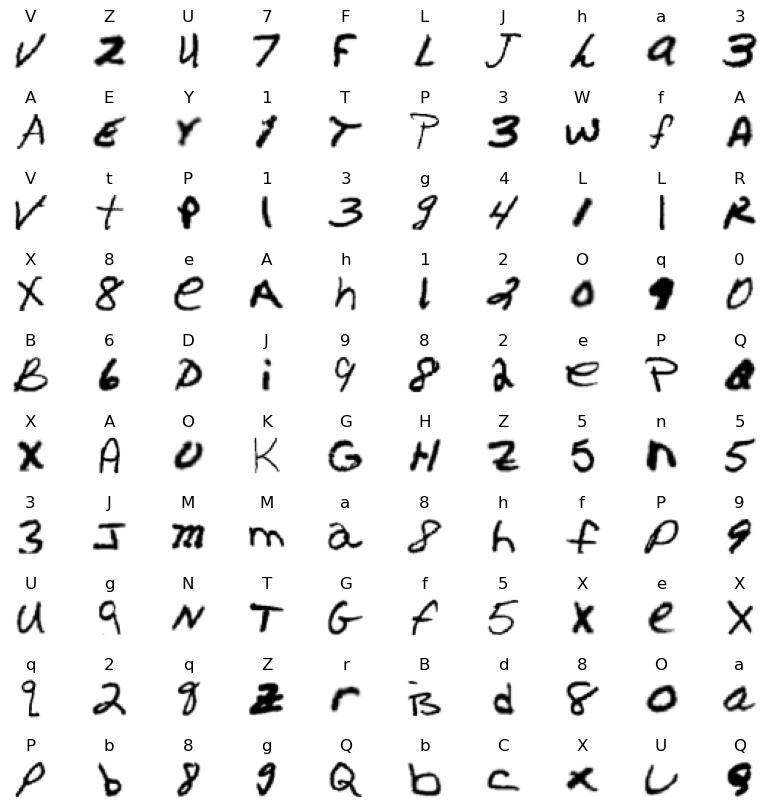

In [27]:
cnt = 0

# this enables to treat tensors like numpy
tf.experimental.numpy.experimental_enable_numpy_behavior()

import matplotlib.cm as cm

train_sub = train_bal.take(100)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=1)
i = 0
for images, labels in train_sub:
    ax = plt.subplot(10,10,i+1)
    plt.imshow(images.reshape((28,28)).transpose(), cmap="binary")
    plt.title(classes_bal[labels.numpy()])
    plt.axis("off")
    i = i + 1

In [28]:
cnt_bal = np.array([label for image, label in train_bal])
cnt_class = np.array([label for image, label in train_class])
cnt_merge = np.array([label for image, label in train_merge])

In [29]:
tes_bal = np.array(classes_bal)[cnt_bal]
tes_class = np.array(classes_class)[cnt_class]
tes_merge = np.array(classes_merge)[cnt_merge]

In [30]:
class_labels_bal, class_counts_bal = np.unique(tes_bal, return_counts=True)
class_labels_class, class_counts_class = np.unique(tes_class, return_counts=True)
class_labels_merge, class_counts_merge = np.unique(tes_merge, return_counts=True)


In [31]:
def plotEMNIST(class_labels, class_counts, title):
    # plt.figure(figsize=(8, 10))
    plt.barh(class_labels, class_counts)
    plt.xlabel('Number of Samples')
    plt.ylabel('Class Label')
    plt.xlim(0,42000)
    plt.title(title)
    for i, v in enumerate(class_counts):
        plt.text(v + 3, i, str(v), fontweight='bold',size='small')
    plt.grid(axis='x')
    plt.tight_layout()

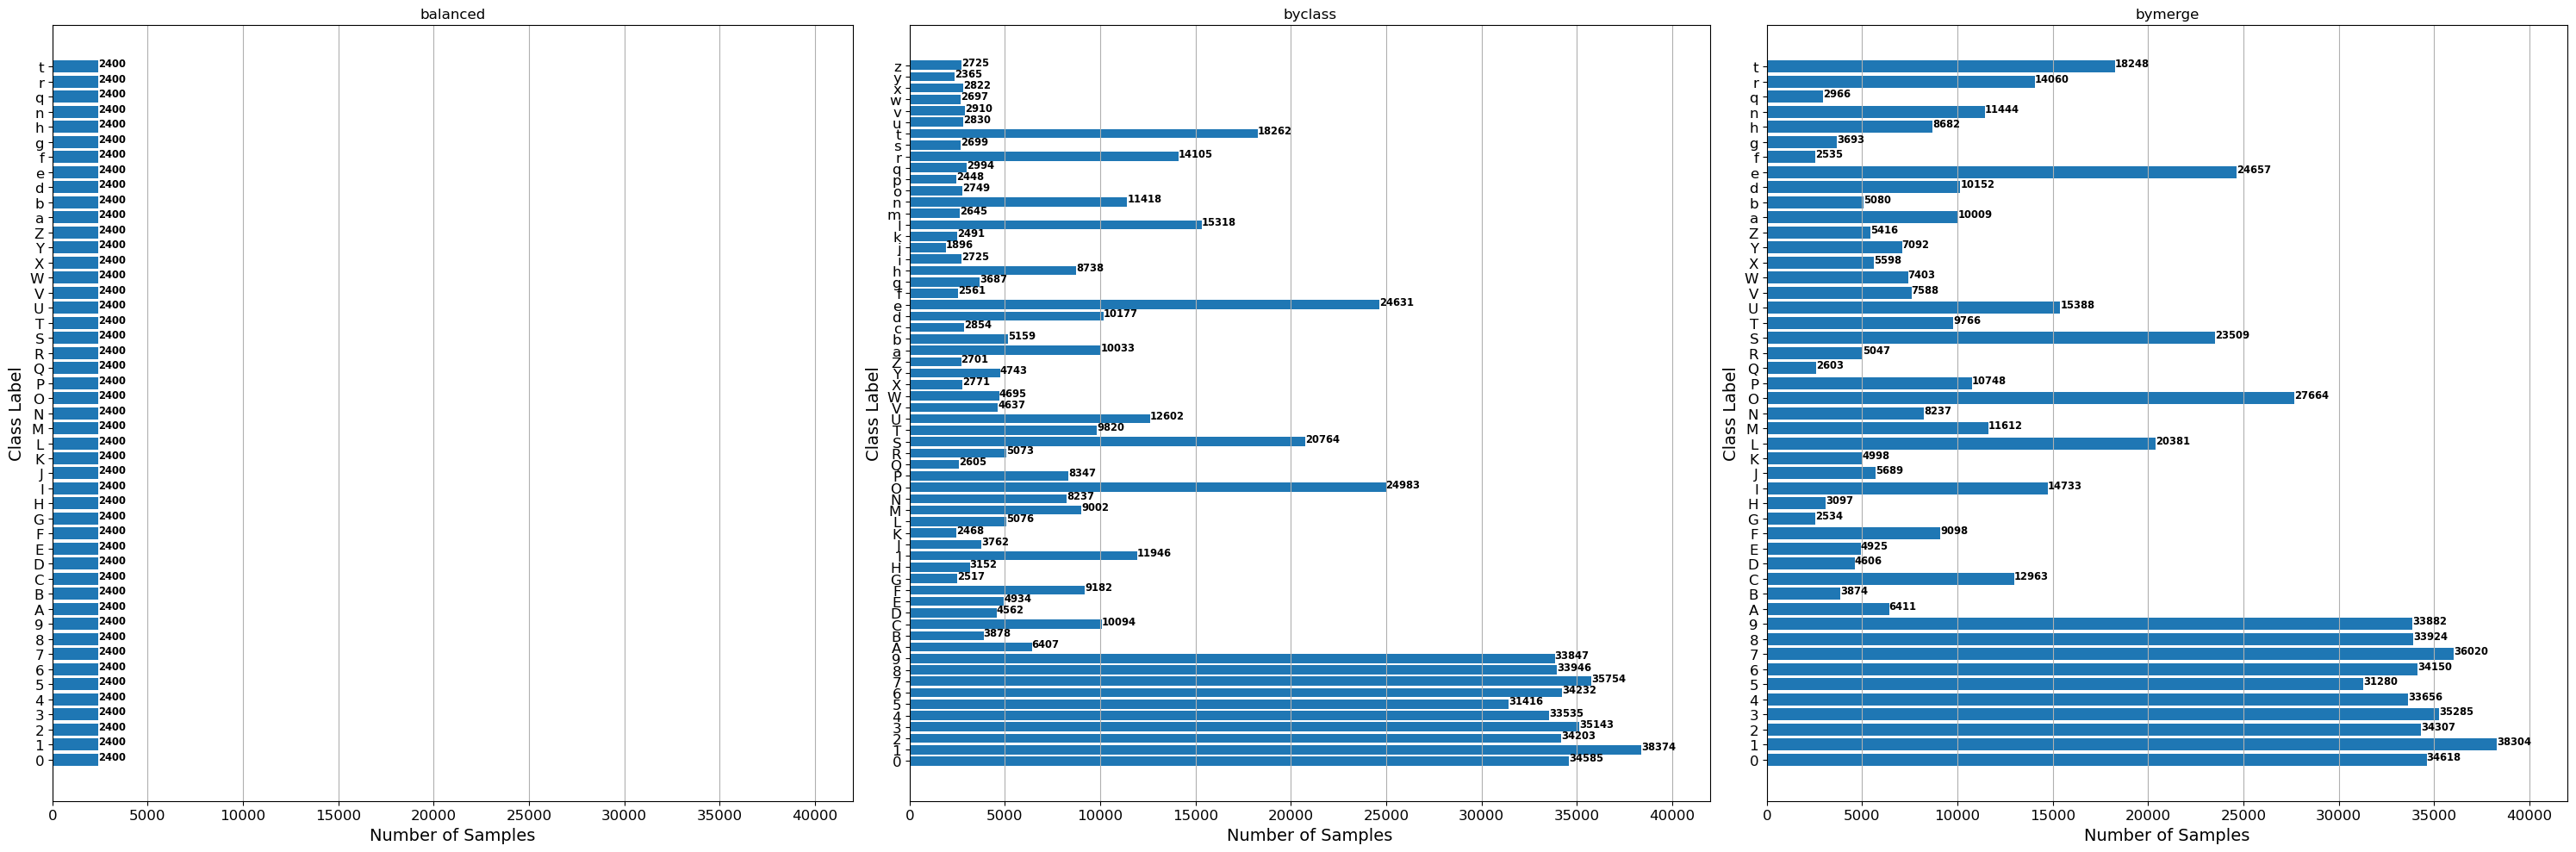

In [32]:
fig = plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plotEMNIST(class_labels_bal,class_counts_bal, "balanced")
plt.subplot(1,3,2)
plotEMNIST(class_labels_class, class_counts_class, "byclass")
plt.subplot(1,3,3)
plotEMNIST(class_labels_merge, class_counts_merge, "bymerge")
plt.show()

bymerge, balanced 에는 일부(c,i,j,k,l,m,o,p,s,u,v,w,x,y,z) 가 존재하지 않음

### todo - class 비교 및 각 label 동일

In [33]:
def preprocess_resnet50(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Convert grayscale to RGB by duplicating the single channel
    image = tf.image.grayscale_to_rgb(image)
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label

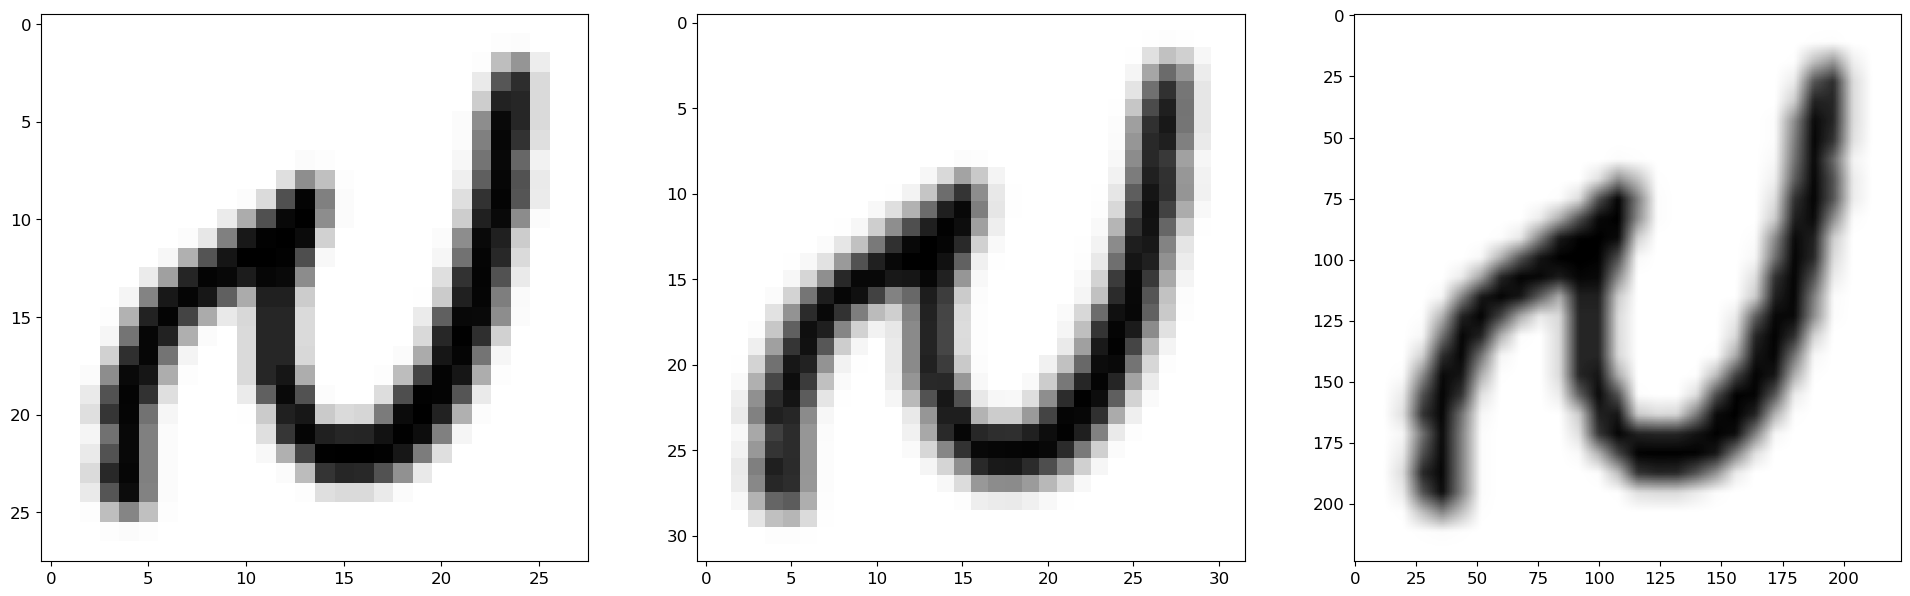

In [34]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

fig = plt.figure(figsize=(24,8))

for img, classes in train_class.take(1):
    plt.subplot(1,3,1)
    plt.imshow(img.reshape(28,28), cmap="binary")
    plt.subplot(1,3,2)
    plt.imshow(tf.image.resize(img, size=(32,32)).reshape(32,32), cmap="binary")
    plt.subplot(1,3,3)
    plt.imshow(tf.image.resize(img, size=(224,224)).reshape(224,224), cmap="binary")

각 `resize()` 결과. 큰 해상도로 설정할수록 pixel 간의 연관성이 파괴됨

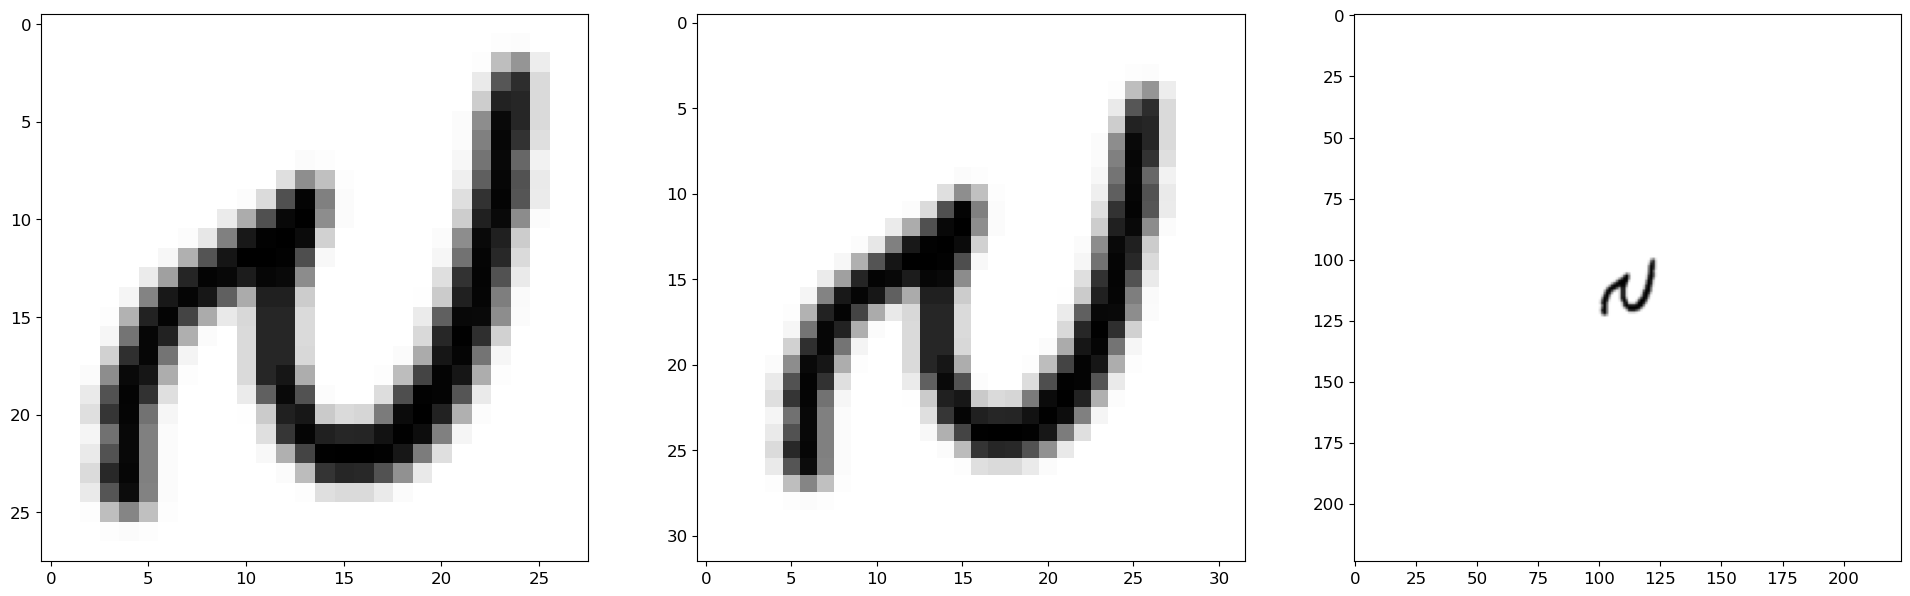

In [35]:
fig = plt.figure(figsize=(24,8))

for img, classes in train_class.take(1):
    plt.subplot(1,3,1)
    plt.imshow(img.reshape(28,28), cmap="binary")
    plt.subplot(1,3,2)
    plt.imshow(tf.image.resize_with_crop_or_pad(img,32,32).reshape(32,32), cmap="binary")
    plt.subplot(1,3,3)
    plt.imshow(tf.image.resize_with_crop_or_pad(img,224,224).reshape(224,224), cmap="binary")

대신에 0-padding을 도입한 결과. (32,32) 까지는 괜찮지만, (228,228) 부터는 많은 공간이 empty 한 상태로 남음

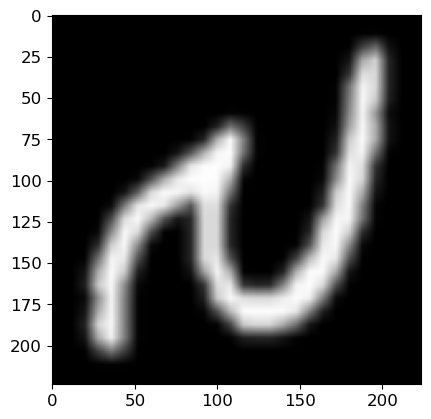

In [36]:
for img, classes in train_class.take(1):
    test1 = tf.image.resize(img, size=(224,224))
    test2 = tf.image.grayscale_to_rgb(test1)
    
    plt.imshow(test2.astype('uint8'))

별 차이는 없어보지만, 기존의 grayscale에 비해서 size가 3배 증가

## train(beta)

[link](https://www.kaggle.com/code/akankshajo/emnist-letter-dataset-97-9-acc-val-acc-91-78)
[and link](https://www.kaggle.com/code/ashenonebot1/handwritten-digits-letters-classification)

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# 
# label_size = len(label_bal)
# 
# class Reshaper(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
# 
#     def transform(self, X):
#         X_reshaped = X.reshape(-1, 28, 28, 1)
#         return X_reshaped
# 
# # Define the pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Step 1: StandardScaler
#     ('reshaper', Reshaper())  # Step 2: Custom Reshaper
# ])
# 
# 
# # Fit and transform the training data
# 
# x_train_processed = pipeline.fit_transform(x_train / 255.)
# y_train_processed = np.eye(label_size)[y_train.astype(int)]
# 
# x_test_processed = pipeline.transform(x_test / 255.)
# 
# y_test_processed = np.eye(label_size)[y_test.astype(int)]

In [ ]:
# print('input shape',x_train_processed.shape)
# print('output shape',y_train.shape)
# # y_train = np.eye(62)[y_train.astype(int)]
# print('output shape',y_train_processed.shape)

In [57]:
import tensorflow_datasets as tfds

(train_data, valid_data, test_data), info = tfds.load("emnist/byclass", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout

def preprocess_lenet5(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label


train_data = train_data.map(preprocess_lenet5)
valid_data = valid_data.map(preprocess_lenet5)
test_data = test_data.map(preprocess_lenet5)

# Batch and prefetch the datasets
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [43]:
#  multiple model architectures
output = 62

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, AvgPool2D

class LeNet(Sequential):
    def __init__(self,num_classes):
        super().__init__()

        self.add(Conv2D(6,5,strides=1,activation='relu',input_shape=(32,32,1),padding='same'))
        self.add(AvgPool2D(2,strides=2))
        self.add(Conv2D(16,5,strides=1,activation='relu'))
        self.add(AvgPool2D(2,strides=2))
        self.add(Conv2D(120,5,strides=1,activation='relu'))
        self.add(Flatten())
        self.add(Dense(84,activation='tanh'))
        self.add(Dense(num_classes,activation='softmax'))
    
        self.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics='accuracy')

In [44]:
model_test = LeNet(output)
model_test.summary()

Model: "le_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_8 (Avera  (None, 16, 16, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 2, 120)         48120     
                                                                 
 flatten_4 (Flatten)         (None, 480)               0  

In [45]:
history_test = model_test.fit(train_data, epochs=5, validation_data=valid_data, batch_size=128)

Epoch 1/5
17449/17449 [==============================] - 88s 5ms/step - loss: 0.5417 - accuracy: 0.8172 - val_loss: 0.4230 - val_accuracy: 0.8475
Epoch 2/5
17449/17449 [==============================] - 87s 5ms/step - loss: 0.4023 - accuracy: 0.8530 - val_loss: 0.4038 - val_accuracy: 0.8523
Epoch 3/5
17449/17449 [==============================] - 84s 5ms/step - loss: 0.3787 - accuracy: 0.8597 - val_loss: 0.3971 - val_accuracy: 0.8557
Epoch 4/5
17449/17449 [==============================] - 85s 5ms/step - loss: 0.3653 - accuracy: 0.8633 - val_loss: 0.3932 - val_accuracy: 0.8569
Epoch 5/5
17449/17449 [==============================] - 84s 5ms/step - loss: 0.3565 - accuracy: 0.8659 - val_loss: 0.3956 - val_accuracy: 0.8559


In [46]:
y_pred = model_test.predict(test_data)

3636/3636 [==============================] - 6s 2ms/step


In [47]:
y_pred = tf.argmax(y_pred, axis=1)

In [48]:
y_true = tf.concat(list(test_data.map(lambda x,y: y)), axis=0)

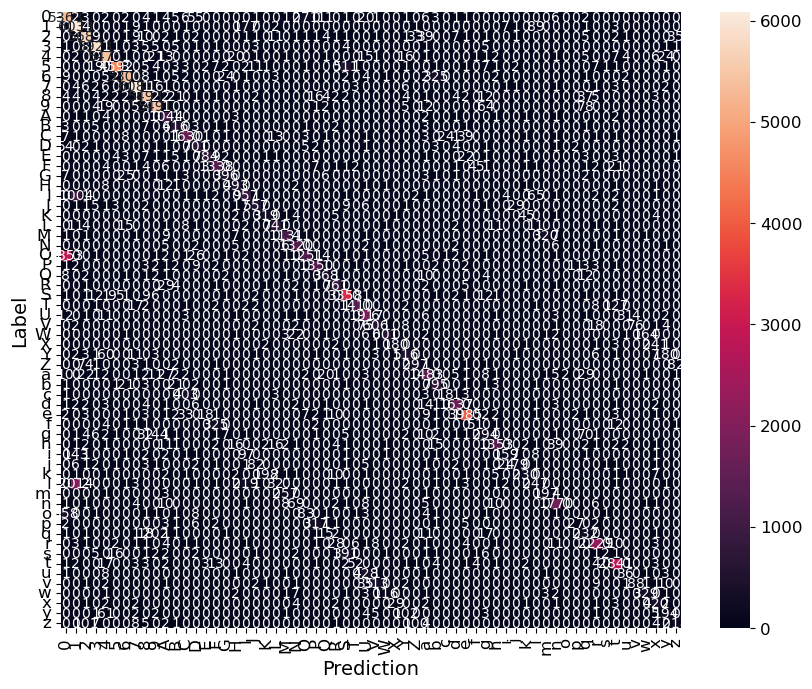

In [88]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classes_class,
            yticklabels=classes_class,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

다른 시각화를 사용해보자..

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)
cm

array([[5306,    2,    1, ...,    0,    0,    0],
       [   0, 6006,    0, ...,    0,    0,    0],
       [   5,    7, 5637, ...,    3,    0,   32],
       ...,
       [   0,    1,    1, ...,  383,    2,    0],
       [   0,    1,    0, ...,    6,  218,    0],
       [   0,    0,   86, ...,    4,    0,  217]])

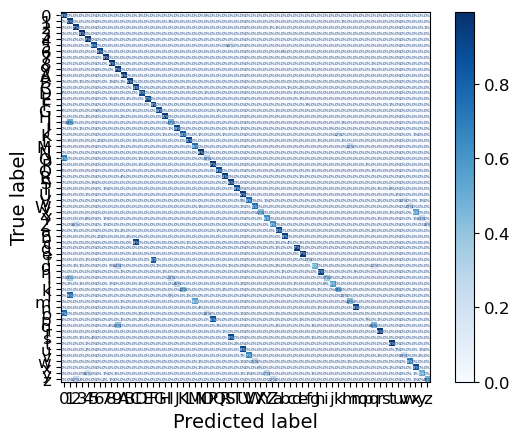

In [108]:
cmp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes_class, normalize="true", values_format=".0%", cmap='Blues')

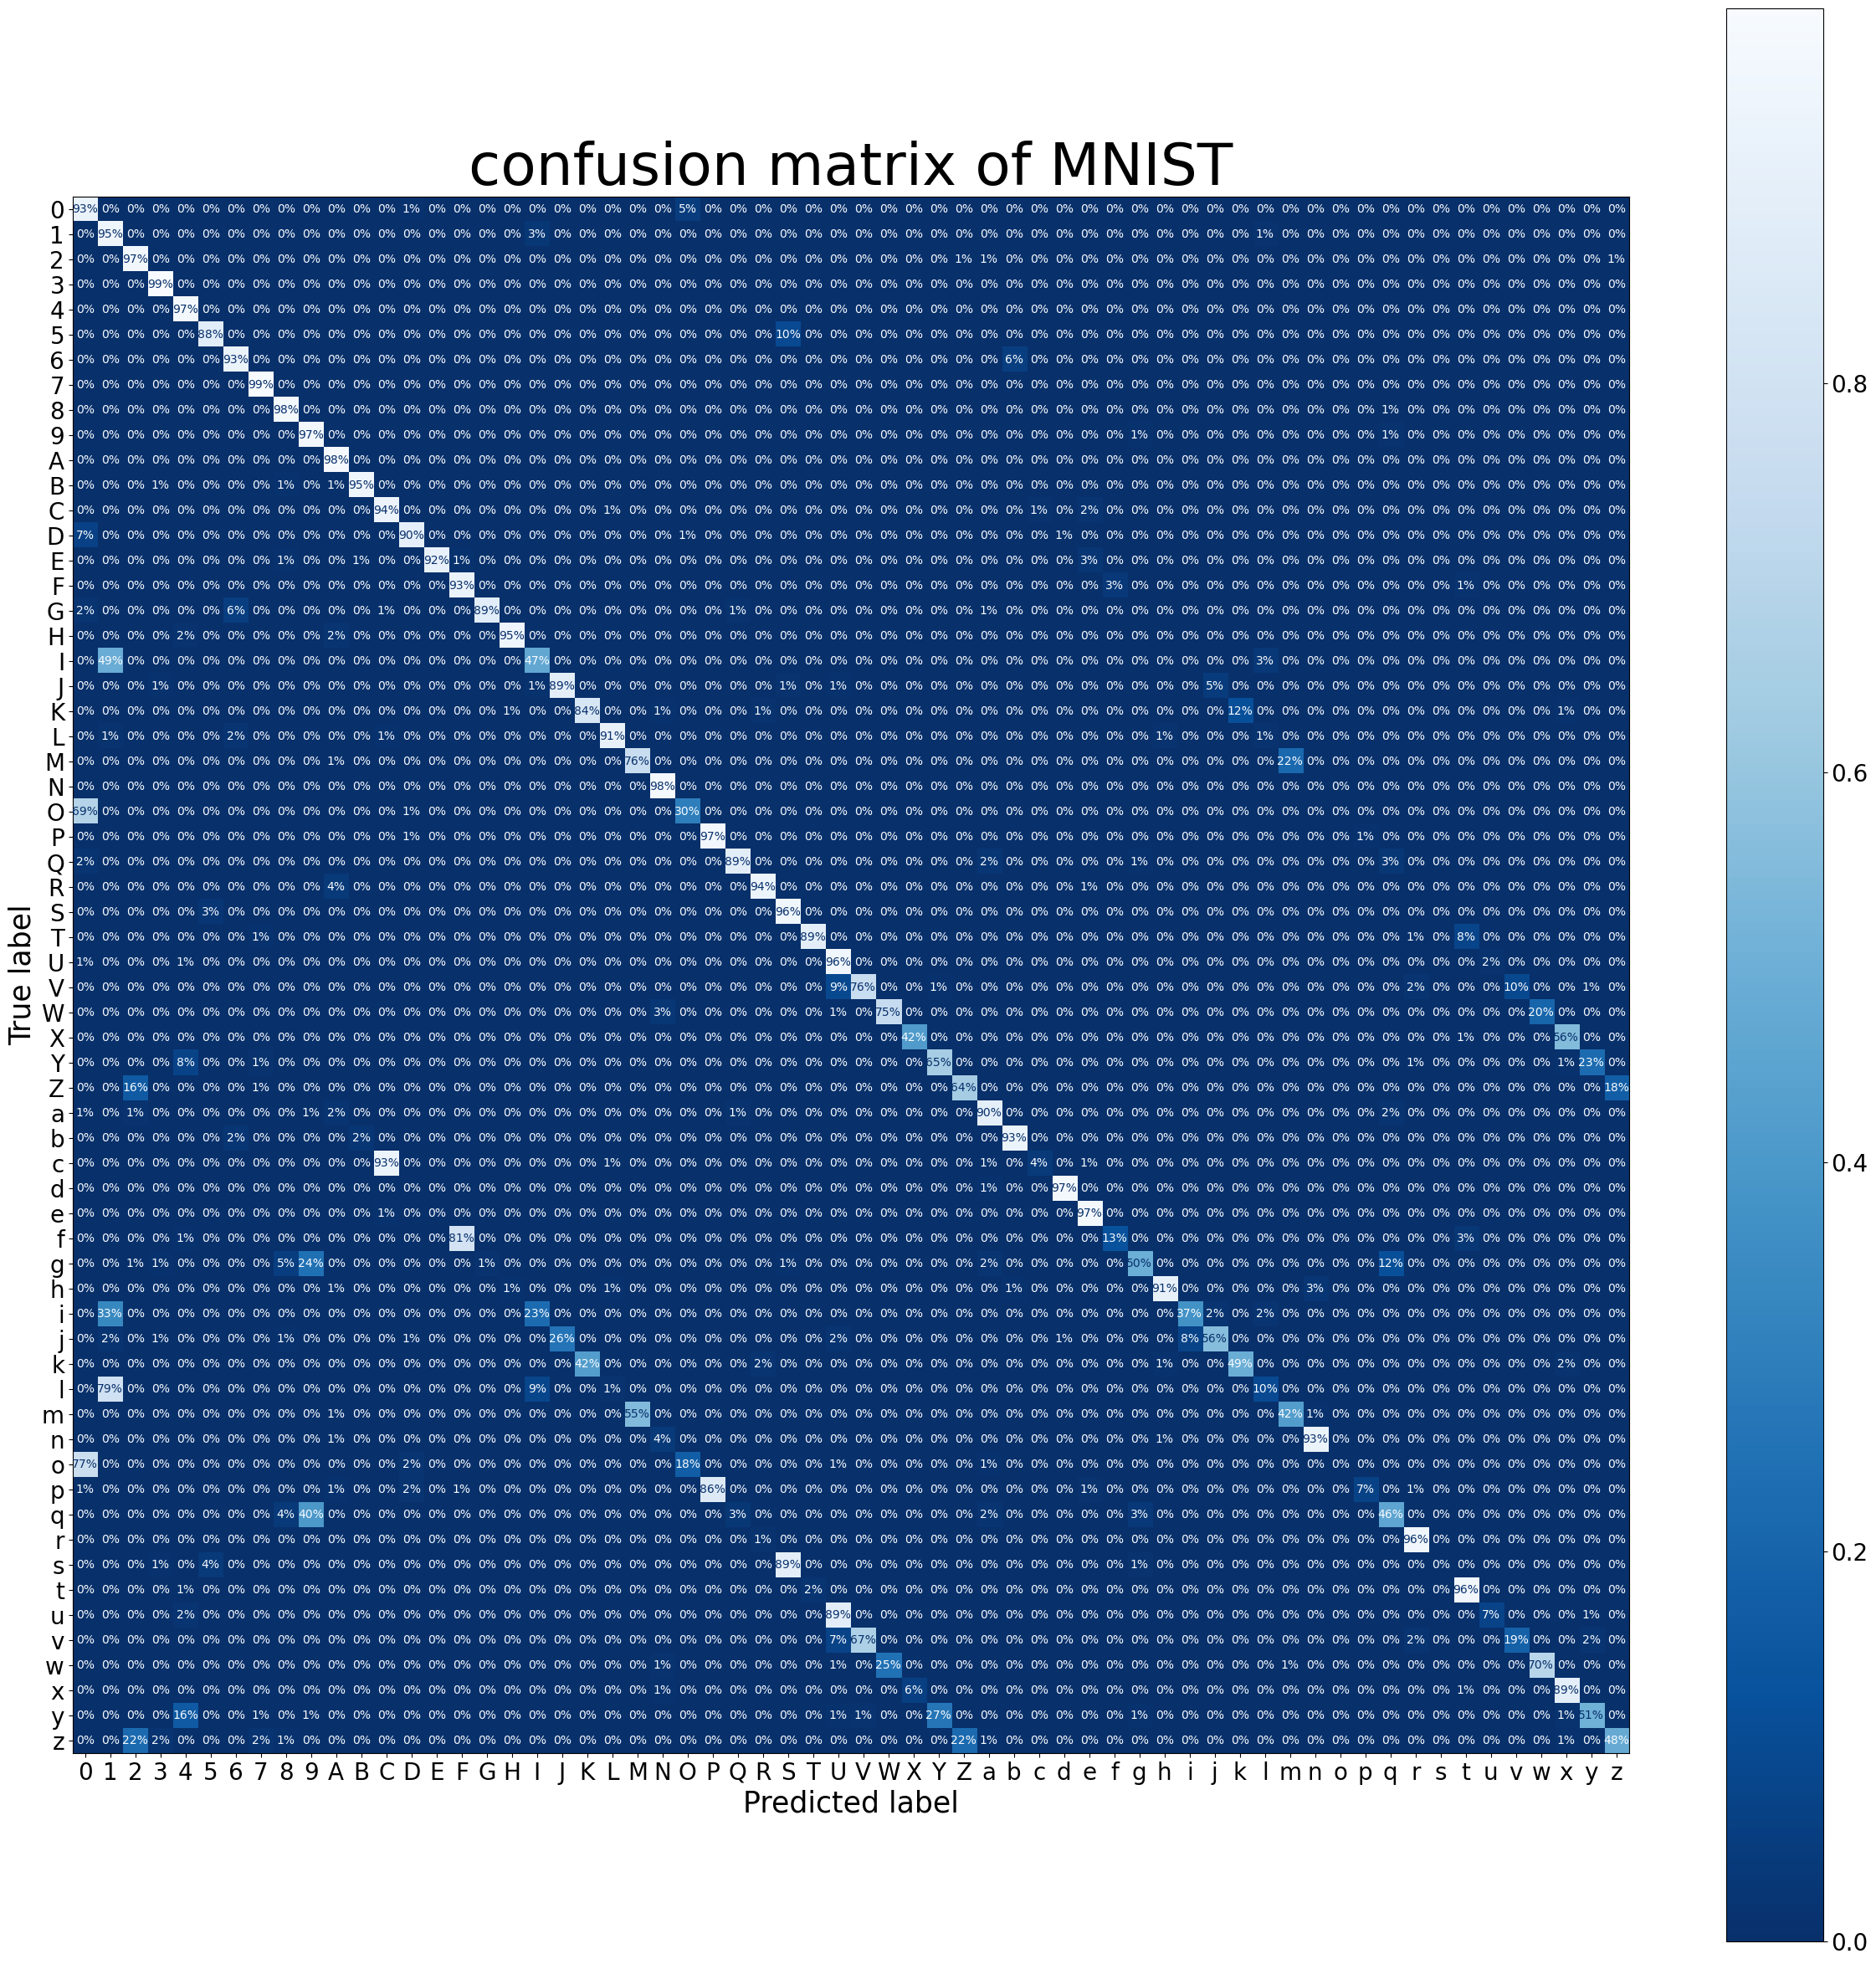

In [139]:
plt.rc('font', size=10)
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=25)   # x,y축 label 폰트 크기

fig, ax = plt.subplots(figsize=(30,30))
plt.title('confusion matrix of MNIST', fontsize=50)
cmp.plot(ax=ax, cmap='Blues_r', values_format='.0%')

In [140]:
save_fig("confusion_matrix_EMNIST_plot_1")

<Figure size 640x480 with 0 Axes>

- 전반적으로 비슷한 알파벳끼리는 구분을 잘 못하는 경향이 있음
- 5 epoch 밖에 진행하지 않은 결과여서 더 학습을 진행하면 잘 구분을 핤 수 있겠지만, 그와 동시에 overfitting 역시 걱정을 해야 함

In [9]:
model_test_epoch_20 = LeNet(output)
history_test_epoch_20 = model_test_epoch_20.fit(train_data, epochs=20, validation_data=valid_data, batch_size=128, callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/20
17449/17449 [==============================] - 136s 8ms/step - loss: 0.5344 - accuracy: 0.8191 - val_loss: 0.4249 - val_accuracy: 0.8461
Epoch 2/20
17449/17449 [==============================] - 129s 7ms/step - loss: 0.4017 - accuracy: 0.8529 - val_loss: 0.4066 - val_accuracy: 0.8526
Epoch 3/20
17449/17449 [==============================] - 133s 8ms/step - loss: 0.3790 - accuracy: 0.8596 - val_loss: 0.4009 - val_accuracy: 0.8547
Epoch 4/20
17449/17449 [==============================] - 132s 8ms/step - loss: 0.3663 - accuracy: 0.8635 - val_loss: 0.3984 - val_accuracy: 0.8549
Epoch 5/20
17449/17449 [==============================] - 128s 7ms/step - loss: 0.3578 - accuracy: 0.8654 - val_loss: 0.3952 - val_accuracy: 0.8571
Epoch 6/20
17449/17449 [==============================] - 131s 8ms/step - loss: 0.3516 - accuracy: 0.8673 - val_loss: 0.3933 - val_accuracy: 0.8575
Epoch 7/20
17449/17449 [==============================] - 132s 8ms/step - loss: 0.3473 - accuracy: 0.8686 - val_

In [4]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotConfusionMartrix(model, data, labels):
    y_pred = model.predict(data)
    y_pred = tf.argmax(y_pred, axis = 1)
    y_true = tf.concat(list(data.map(lambda x, y: y)), axis=0)

    plt.rc('font', size=10)
    # plt.grid(None)
    plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
    plt.rc('axes', labelsize=25)  # x,y축 label 폰트 크기

    fig, ax = plt.subplots(figsize=(30, 30))
    ax.grid(False)
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true",
                                                  values_format=".0%", cmap='Blues_r', ax=ax)

3636/3636 [==============================] - 7s 2ms/step


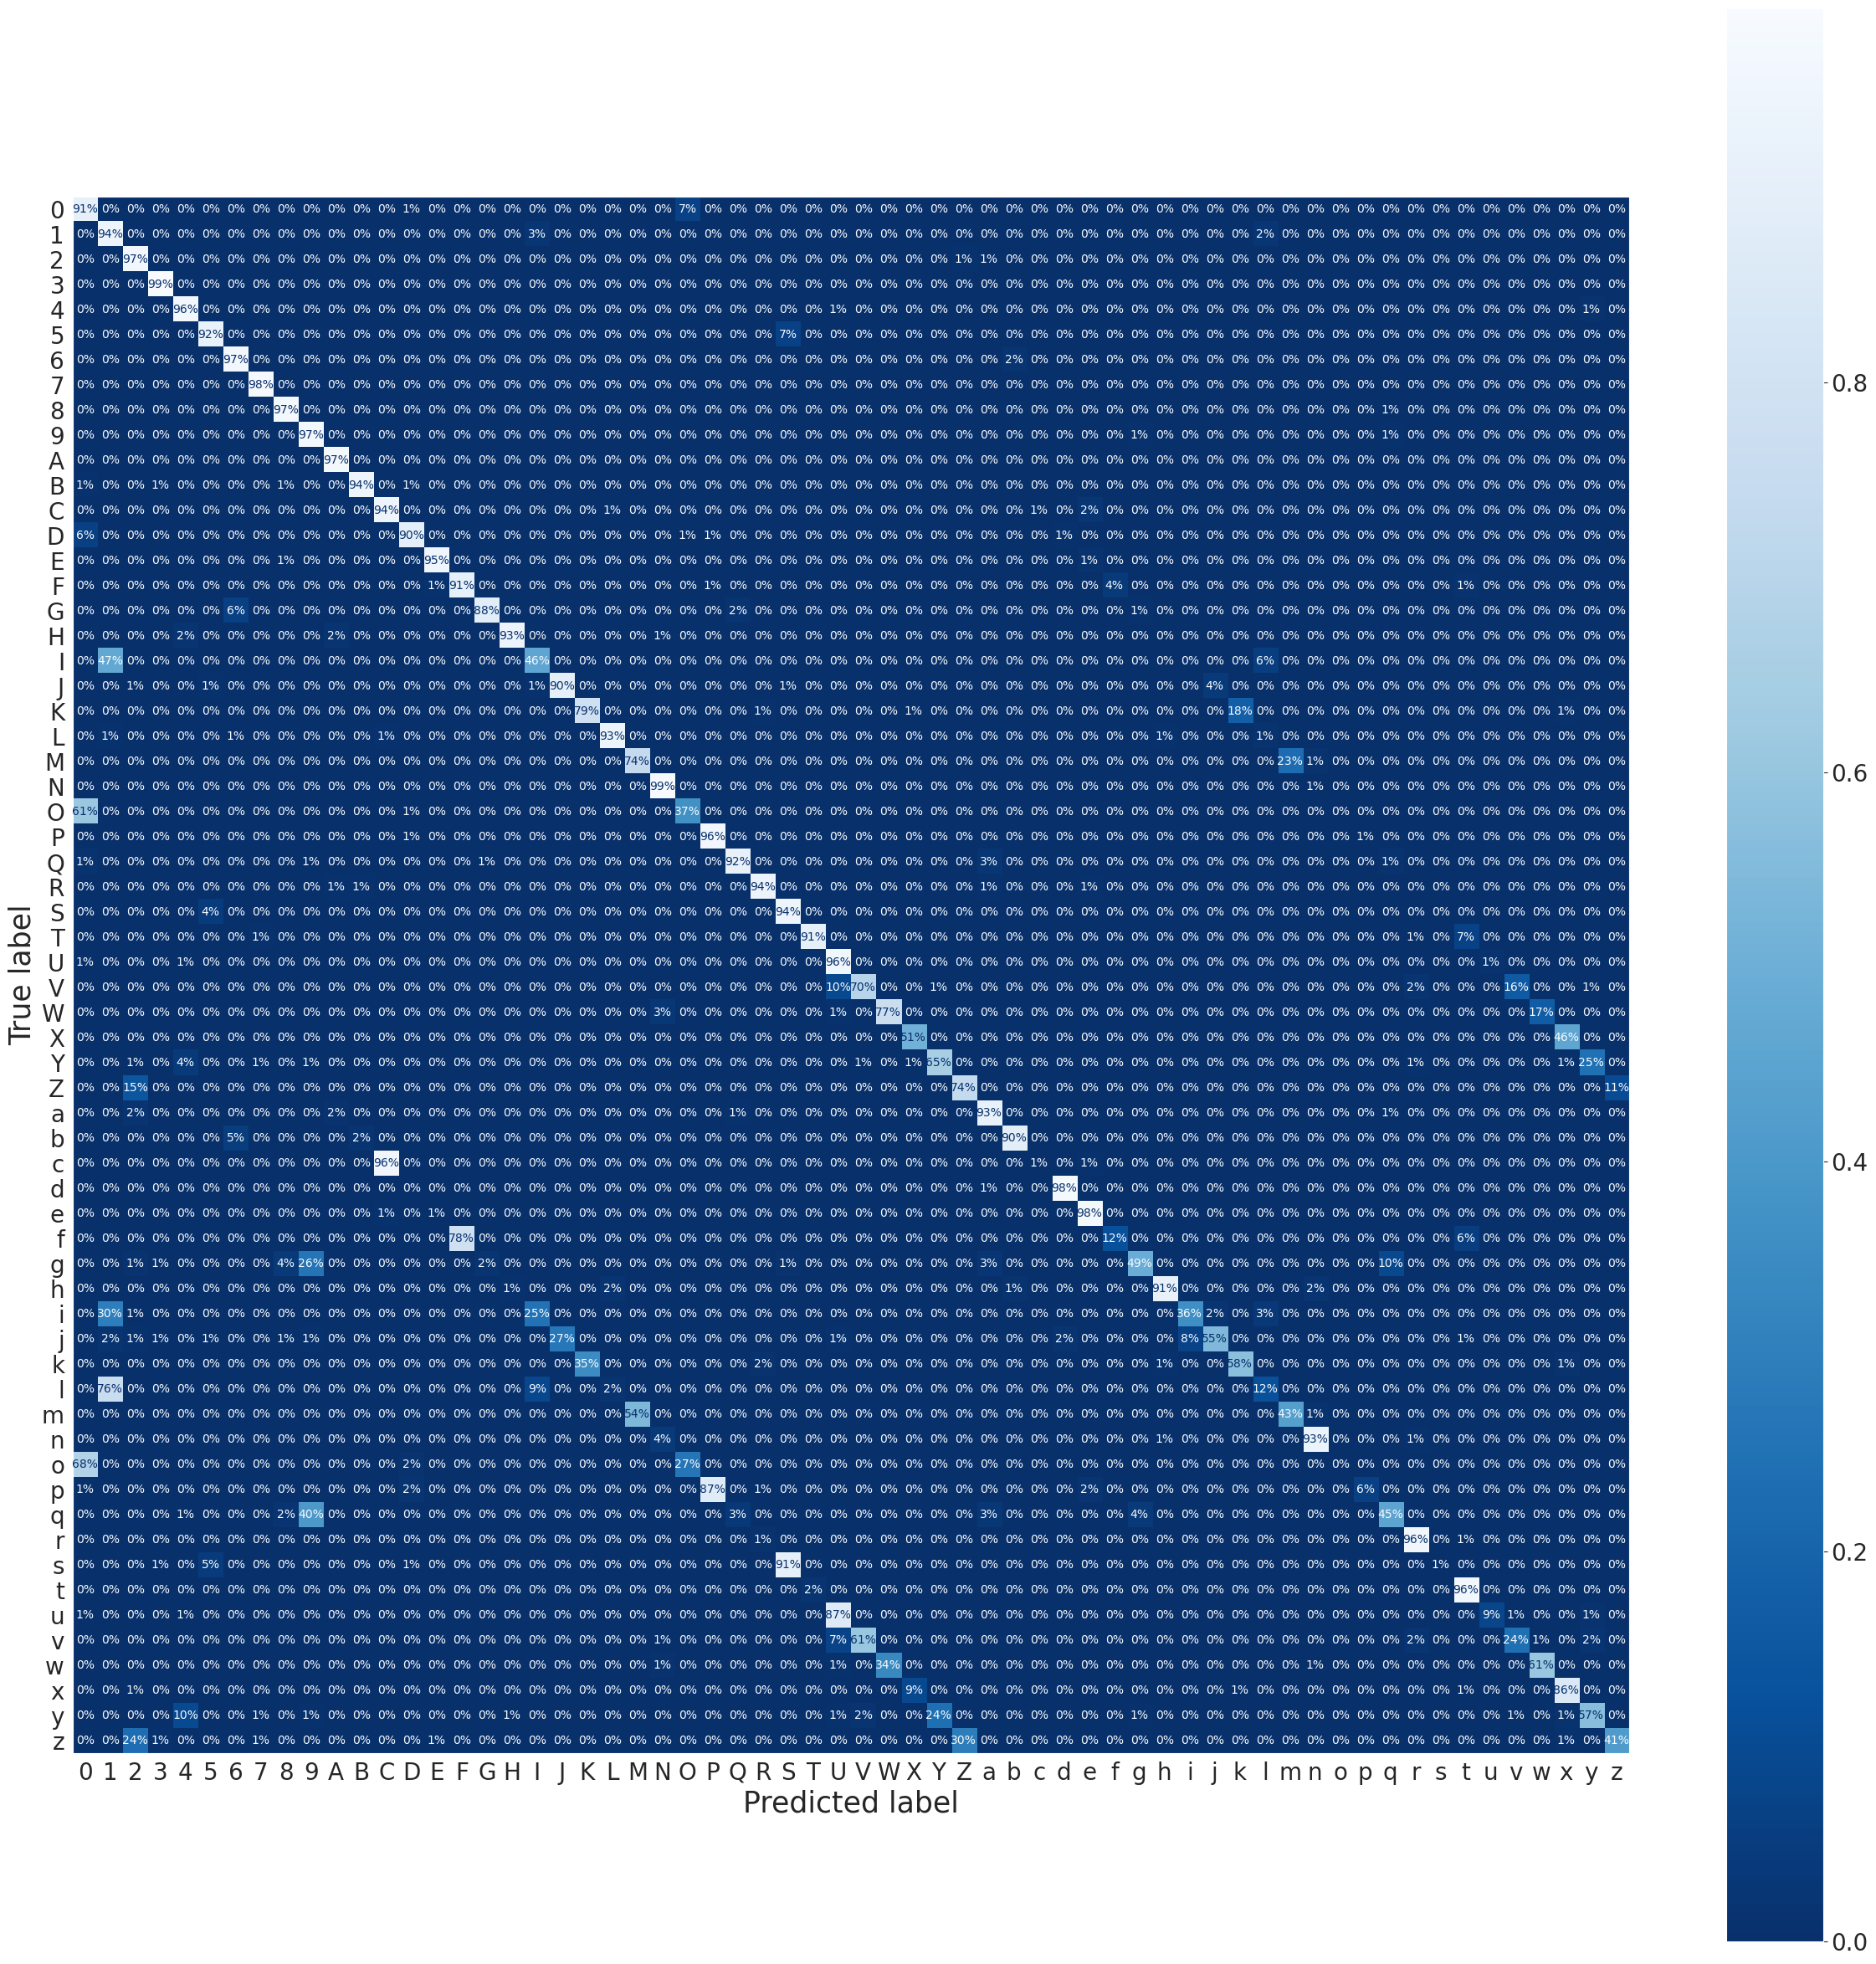

In [74]:
plotConfusionMartrix(model_test_epoch_20, test_data, classes_class)

해결 방안
1. ~~data augumentation~~
2. hidden layers 추가(deep)
3. dropout(overfit 방지)

In [20]:
# bring resNet model

MODEL_PATH = Path() / "models" / "ResNet50"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

model_resnet_epoch_20 = tf.keras.models.load_model(str(MODEL_PATH) + "/light_resnet_adamax_sample.keras")

In [26]:
import tensorflow_datasets as tfds

(train_data_resnet, valid_data_resnet, test_data_resnet), info = tfds.load("emnist/byclass", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)

def preprocess_resnet50(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Convert grayscale to RGB by duplicating the single channel
    image = tf.image.grayscale_to_rgb(image)
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label


train_data_resnet = train_data_resnet.map(preprocess_resnet50)
valid_data_resnet = valid_data_resnet.map(preprocess_resnet50)
test_data_resnet = test_data_resnet.map(preprocess_resnet50)
batch_size = 32
train_data_resnet = train_data_resnet.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data_resnet = valid_data_resnet.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data_resnet = test_data_resnet.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2024-06-09 04:22:54.203381: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


3636/3636 [==============================] - 14s 3ms/step


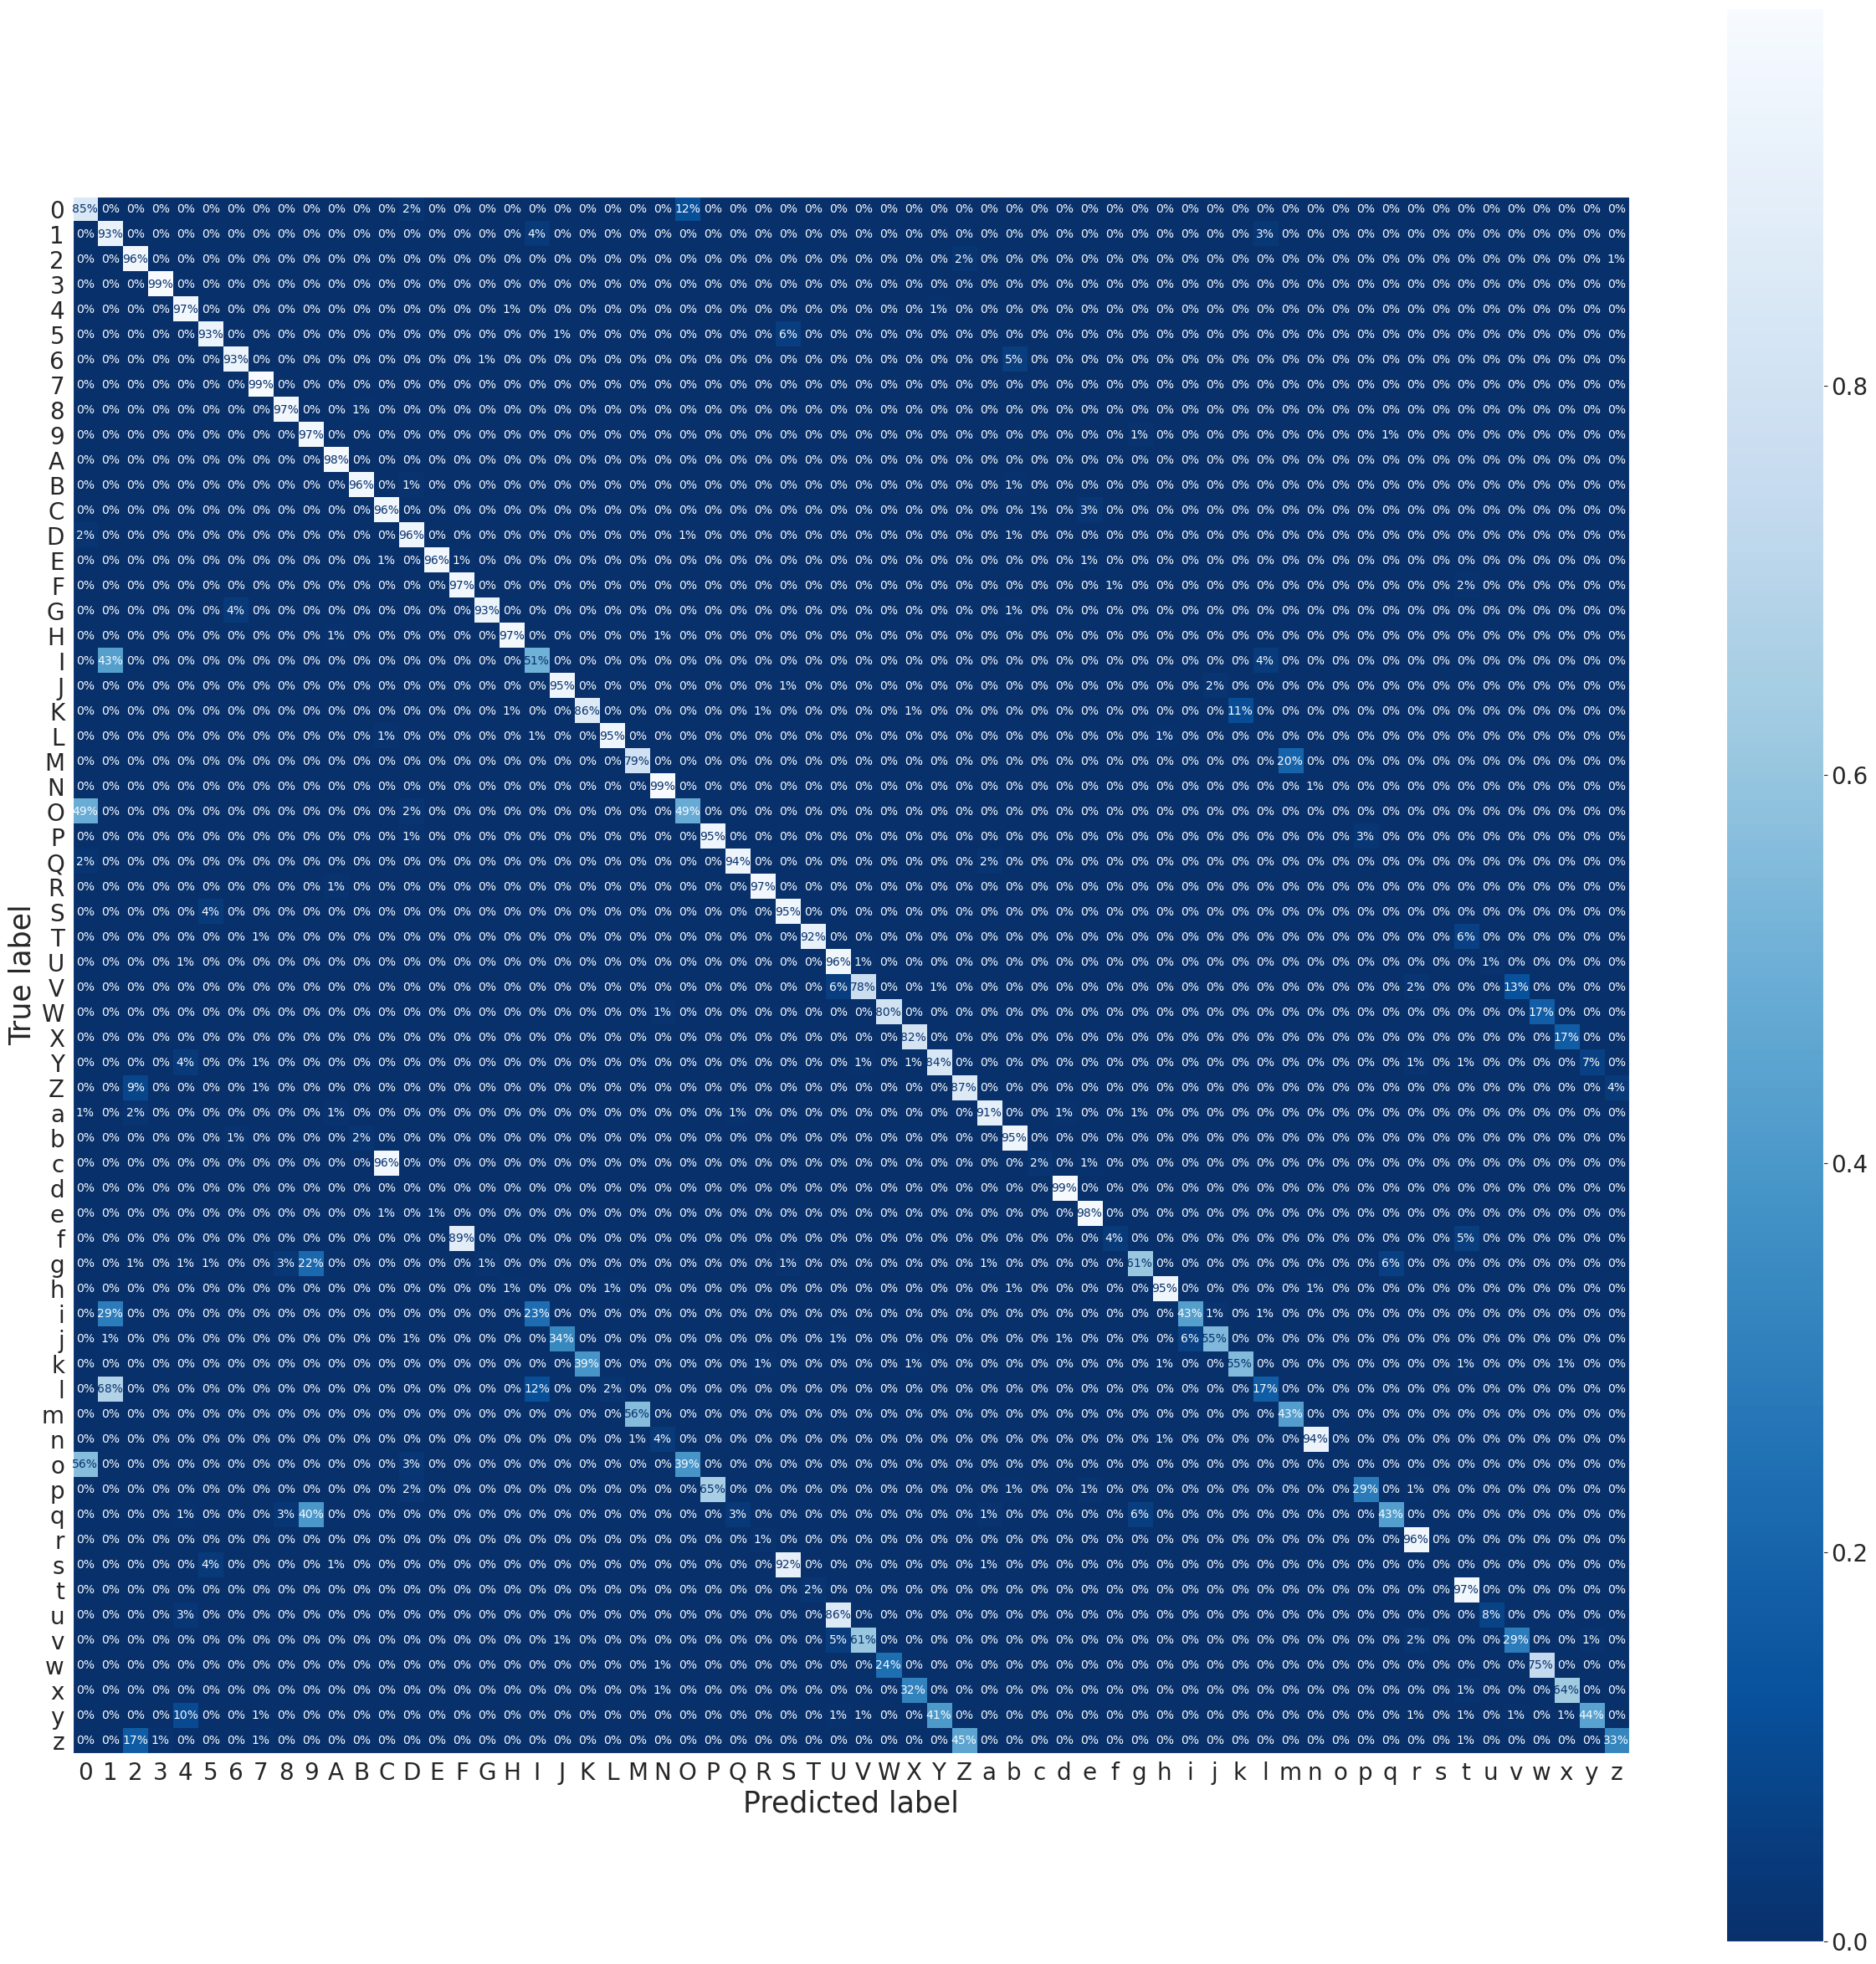

In [27]:
plotConfusionMartrix(model_resnet_epoch_20, test_data_resnet, classes_class)

더 깊은 layer를 가진 model이라고 잘 구분하는 거 같지는 않다.. 이 문제가 없는 bymerge로 진행해보자

In [35]:
(train_data_bymerge, valid_data_bymerge, test_data_bymerge), info = tfds.load("emnist/bymerge", split=["train[:80%]", "train[80%:]", "test"],
                                                      as_supervised=True, with_info=True)
print(f"size of train: {train_data.cardinality().numpy()}")
print(f"size of validation: {valid_data.cardinality().numpy()}")
print(f"size of test: {test_data.cardinality().numpy()}")
num_class = info.features["label"].num_classes
print(num_class)

size of train: 17449
size of validation: 4363
size of test: 3636
47


In [36]:
train_data_bymerge = train_data_bymerge.map(preprocess_lenet5)
valid_data_bymerge = valid_data_bymerge.map(preprocess_lenet5)
test_data_bymerge = test_data_bymerge.map(preprocess_lenet5)
batch_size = 32
train_data_bymerge = train_data_bymerge.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data_bymerge = valid_data_bymerge.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data_bymerge = test_data_bymerge.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
model_test_bymerge = LeNet(47)
model_test_bymerge.summary()

Model: "le_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_6 (Avera  (None, 16, 16, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_7 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 120)         48120     
                                                                 
 flatten_3 (Flatten)         (None, 480)               0  

In [40]:
history_bymerge = model_test_bymerge.fit(train_data_bymerge, epochs=5, validation_data=valid_data_bymerge)

Epoch 1/5
17449/17449 [==============================] - 90s 5ms/step - loss: 0.4149 - accuracy: 0.8580 - val_loss: 0.3216 - val_accuracy: 0.8799
Epoch 2/5
17449/17449 [==============================] - 86s 5ms/step - loss: 0.2985 - accuracy: 0.8907 - val_loss: 0.2967 - val_accuracy: 0.8883
Epoch 3/5
17449/17449 [==============================] - 87s 5ms/step - loss: 0.2774 - accuracy: 0.8972 - val_loss: 0.2931 - val_accuracy: 0.8899
Epoch 4/5
17449/17449 [==============================] - 90s 5ms/step - loss: 0.2655 - accuracy: 0.9005 - val_loss: 0.2952 - val_accuracy: 0.8894
Epoch 5/5
17449/17449 [==============================] - 84s 5ms/step - loss: 0.2581 - accuracy: 0.9025 - val_loss: 0.3015 - val_accuracy: 0.8880


3636/3636 [==============================] - 7s 2ms/step


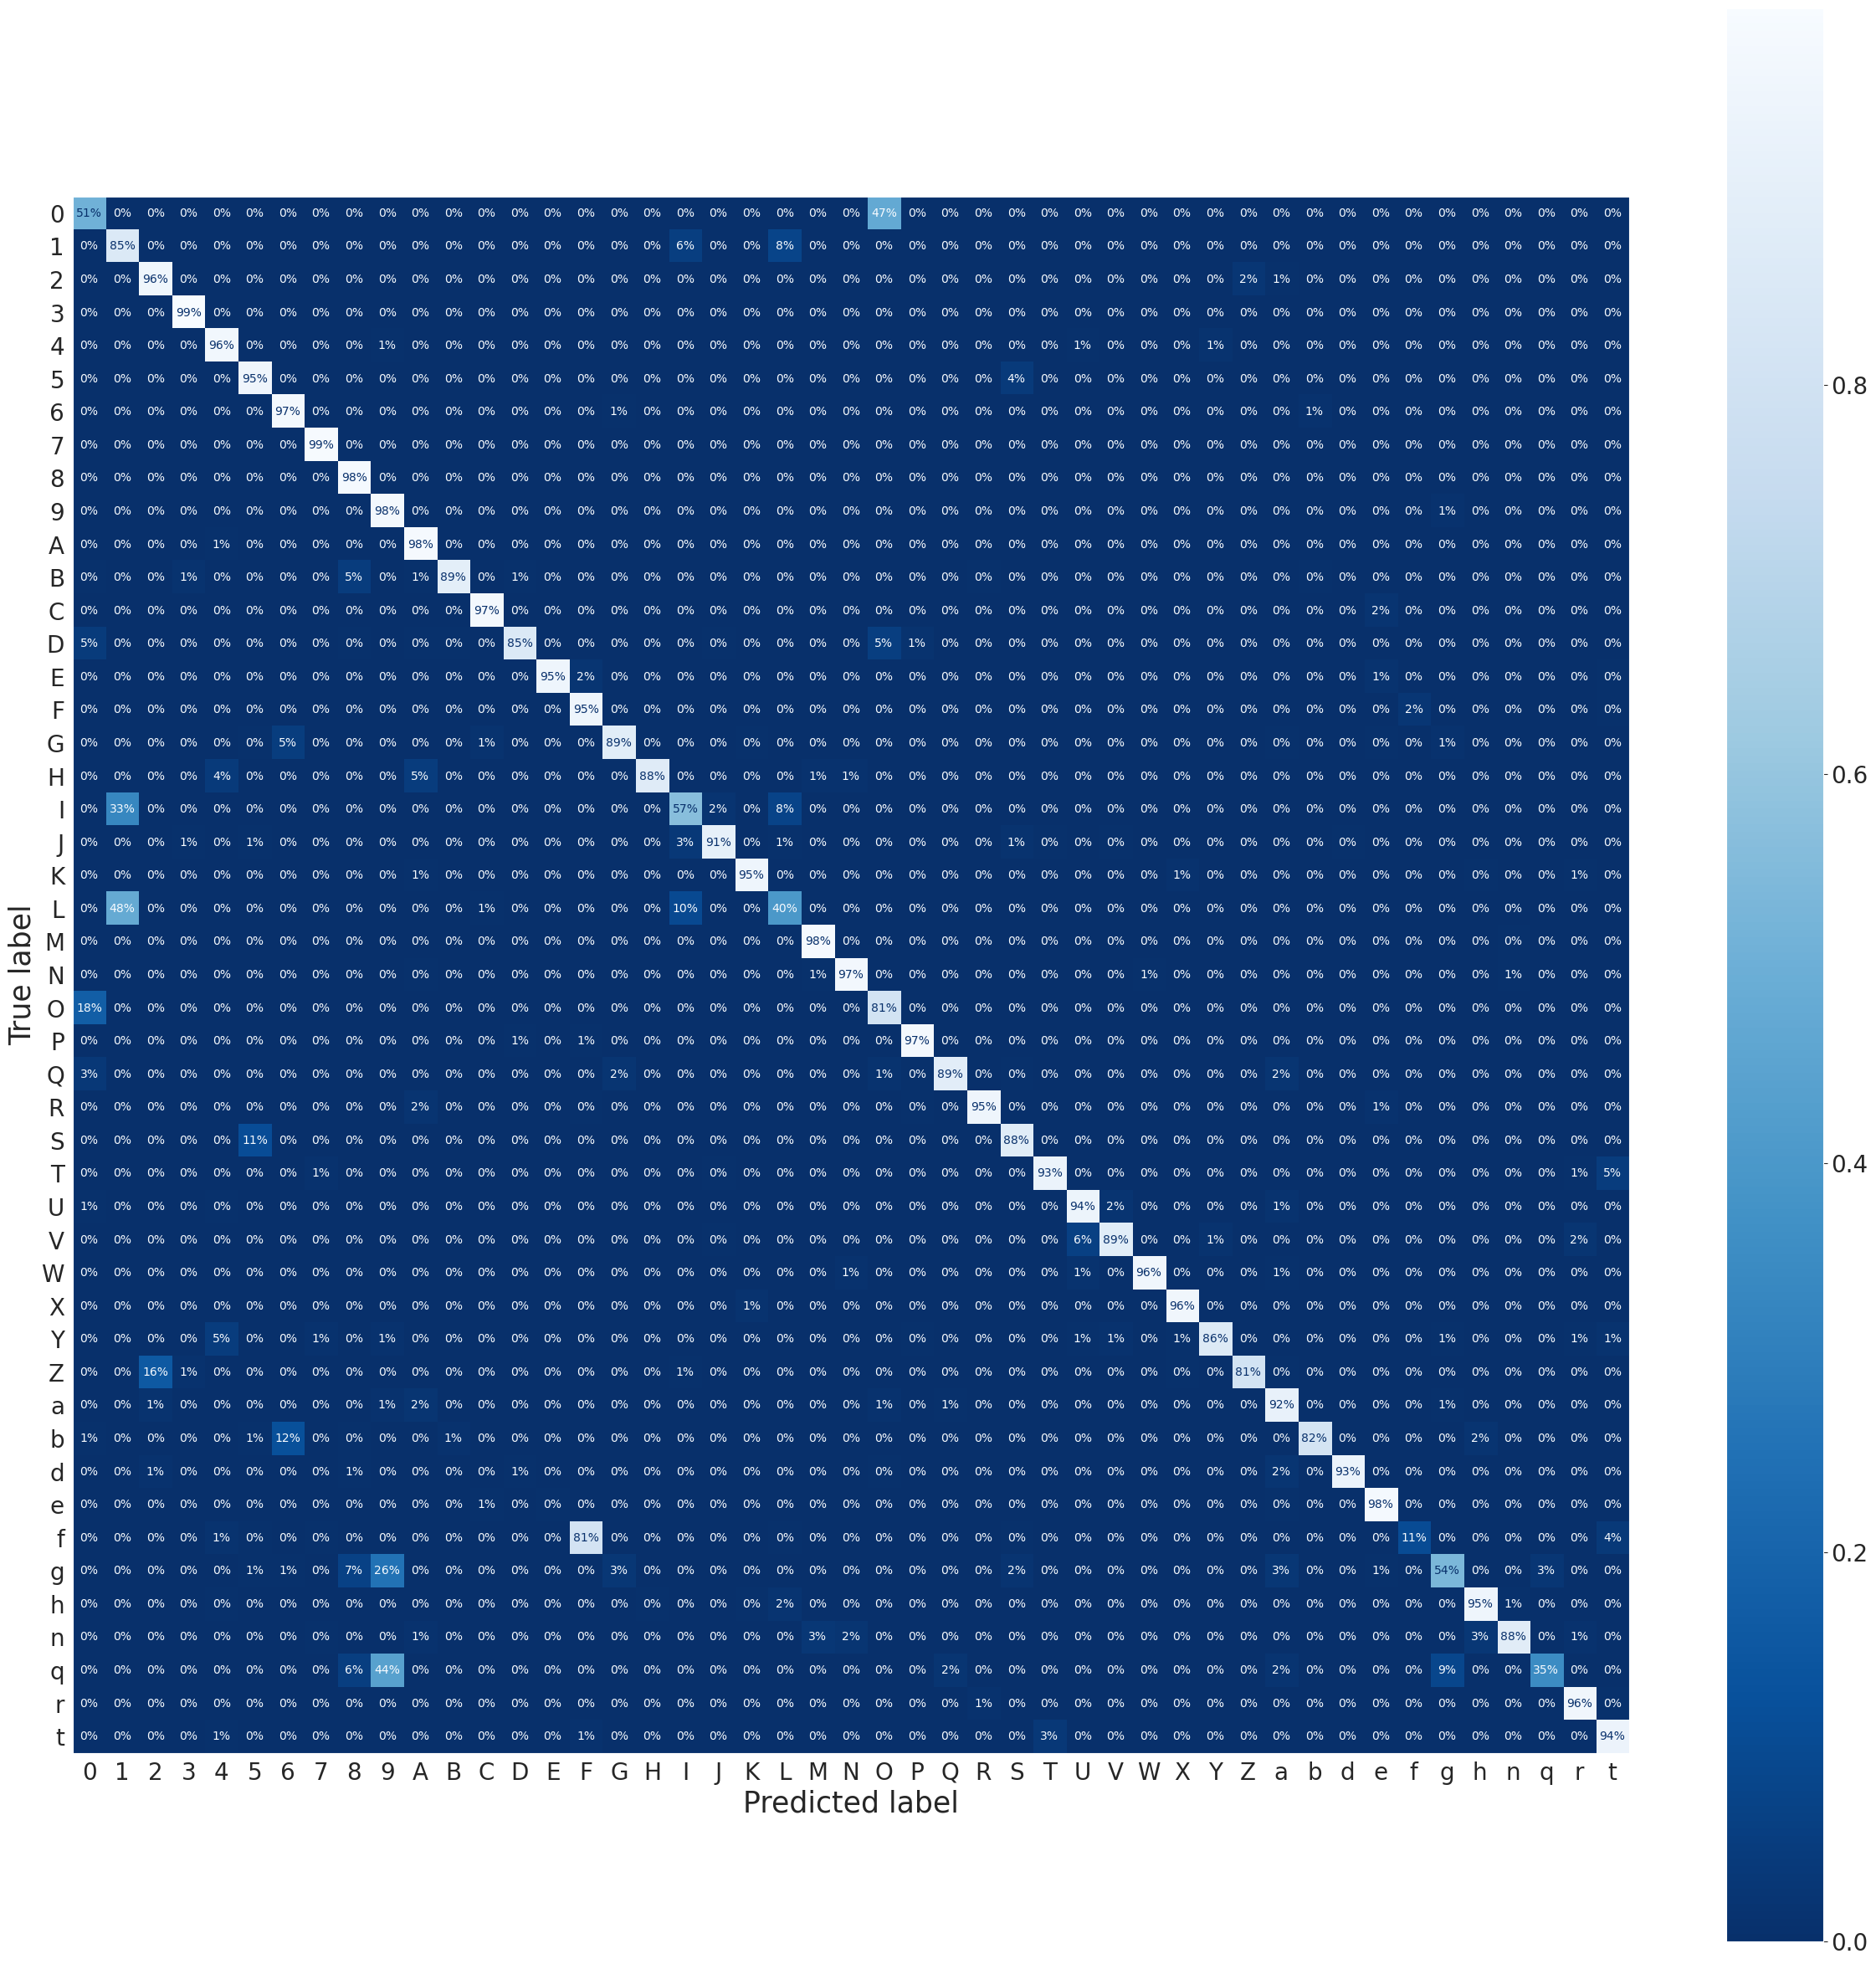

In [41]:
plotConfusionMartrix(model_test_bymerge, test_data_bymerge, classes_merge)